# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [131]:
# import libraries
import pandas as pd
import re
from sqlalchemy import create_engine

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.metrics import confusion_matrix, coverage_error, f1_score, precision_score, recall_score, classification_report, accuracy_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from context import haystack
from haystack.modeling.custom_features import QuestionMarkFeature, TextLengthFeature

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\guischmitd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\guischmitd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\guischmitd\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# load data from database
engine = create_engine('sqlite:///../data/DisasterResponse.db')
df = pd.read_sql_table('categorized_messages', engine)
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
X = df['message']
target_cols = [col for col in df.columns if col not in ('id', 'message', 'original', 'genre')]
Y = df[target_cols]

In [4]:
for col in Y.columns:
    print()
    print(Y[col].value_counts())


1    19874
0     6115
Name: related, dtype: int64

0    21525
1     4464
Name: request, dtype: int64

0    25872
1      117
Name: offer, dtype: int64

0    15149
1    10840
Name: aid_related, dtype: int64

0    23909
1     2080
Name: medical_help, dtype: int64

0    24679
1     1310
Name: medical_products, dtype: int64

0    25265
1      724
Name: search_and_rescue, dtype: int64

0    25518
1      471
Name: security, dtype: int64

0    25130
1      859
Name: military, dtype: int64

0    25989
Name: child_alone, dtype: int64

0    24320
1     1669
Name: water, dtype: int64

0    23072
1     2917
Name: food, dtype: int64

0    23681
1     2308
Name: shelter, dtype: int64

0    25585
1      404
Name: clothing, dtype: int64

0    25386
1      603
Name: money, dtype: int64

0    25691
1      298
Name: missing_people, dtype: int64

0    25115
1      874
Name: refugees, dtype: int64

0    24797
1     1192
Name: death, dtype: int64

0    22548
1     3441
Name: other_aid, dtype: int64

0    24

### 2. Write a tokenization function to process your text data

In [5]:
def tokenize(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = stopwords.words('english')
    
    # normalize (remove capitalization)
    text = text.lower()
    
    # replace URLs
    text = re.sub('(http(s)?:\/\/.)?(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)', 'urlplaceholder', text)
    
    # remove punctuation
    text = re.sub('\W', ' ', text)
    
    sentences = sent_tokenize(text)
    
    tokens = []
    for sent in sentences:
        tokens.extend([lemmatizer.lemmatize(word) for word in word_tokenize(sent) if word not in stop_words])
    
    return tokens

test_msg = X.sample(1).iloc[0]
print(test_msg)
tokenize(test_msg)

The Permanent Mission of the Islamic State of Afghanistan to the United Nations in New York has issued an appeal from the Islamic State of Afghanistan, Office of the President, to the United Nations, the International Committee of the Red Cross, friendly Governments, international relief agencies and non-governmental organizations, to respond generously with humanitarian aid to the needs of the earthquake victims.


['permanent',
 'mission',
 'islamic',
 'state',
 'afghanistan',
 'united',
 'nation',
 'new',
 'york',
 'issued',
 'appeal',
 'islamic',
 'state',
 'afghanistan',
 'office',
 'president',
 'united',
 'nation',
 'international',
 'committee',
 'red',
 'cross',
 'friendly',
 'government',
 'international',
 'relief',
 'agency',
 'non',
 'governmental',
 'organization',
 'respond',
 'generously',
 'humanitarian',
 'aid',
 'need',
 'earthquake',
 'victim']

In [6]:
test_msg = 'How will things be for tomorrow?'
print(test_msg)
tokenize(test_msg)


How will things be for tomorrow?


['thing', 'tomorrow']

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [7]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier()))
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [8]:
seed = 51
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.3, random_state=seed)

In [9]:
X_train.shape, y_train.shape

((18192,), (18192, 36))

In [10]:
max_samples = 250
pipeline.fit(X_train.iloc[:max_samples], y_train.iloc[:max_samples])

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x000002715EDF6D30>)),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier()))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [12]:
y_pred = pipeline.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=y_test.columns)

In [13]:
print(classification_report(y_test, y_pred, target_names=y_test.columns))

                        precision    recall  f1-score   support

               related       0.79      0.97      0.87      5968
               request       0.89      0.12      0.21      1361
                 offer       0.00      0.00      0.00        41
           aid_related       0.73      0.25      0.38      3269
          medical_help       0.00      0.00      0.00       633
      medical_products       0.00      0.00      0.00       387
     search_and_rescue       0.00      0.00      0.00       230
              security       0.00      0.00      0.00       136
              military       0.00      0.00      0.00       238
           child_alone       0.00      0.00      0.00         0
                 water       0.00      0.00      0.00       490
                  food       0.96      0.10      0.19       897
               shelter       0.92      0.02      0.03       723
              clothing       0.00      0.00      0.00       115
                 money       0.00      

In [14]:
for i, col in enumerate(y_test.columns):
        print('*** Category:', col, '***')
        print(classification_report(y_test[col], y_pred[col]))

classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\code\udacity\disaster-response-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\code\udacity\disaster-response-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\code\uda

d:\code\udacity\disaster-response-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\code\udacity\disaster-response-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\code\udacity\disaster-response-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\code\udacity\disaster-response-classi

<AxesSubplot:>

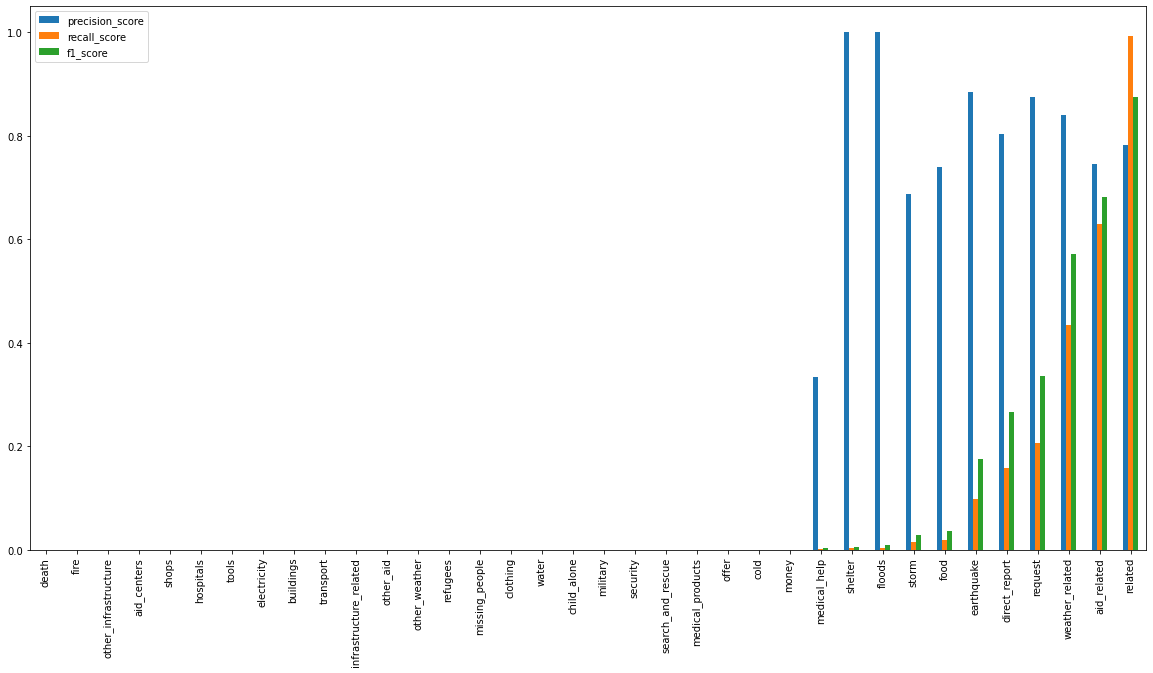

In [130]:
def eval_metrics_per_category(y_test, y_pred, metrics=[precision_score, recall_score, f1_score, accuracy_score]):
    results = {}
    
    for col in y_test.columns:
        results[col] = {}
        for metric in metrics:
            results[col].update({metric.__name__ : metric(y_test[col], y_pred[col])})
    return pd.DataFrame(results).T

res = eval_metrics_per_category(y_test, y_pred)
res[['precision_score', 'recall_score', 'f1_score']].sort_values('f1_score').plot.bar(figsize=(20, 10))

<AxesSubplot:>

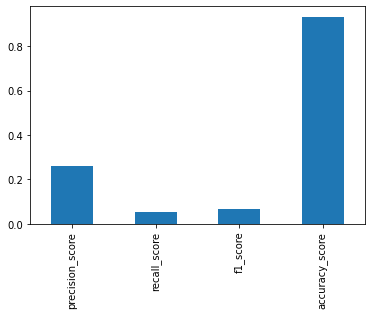

In [17]:
macro_res = res.mean()
macro_res.plot.bar()

In [18]:
# pipeline.get_params()

### 6. Improve your model
Use grid search to find better parameters. 

In [ ]:
parameters = {
    'clf__estimator__max_depth': [3, 5, 8],
    'clf__estimator__n_estimators': [20, 50, 100, 200],
    'clf__estimator': [RandomForestClassifier(), GradientBoostingClassifier()],
    'clf__n_jobs': [-1]
}

cv = GridSearchCV(pipeline, parameters, verbose=4)

In [36]:
cv.fit(X, Y)

fier\.venv\lib\site-packages\sklearn\utils\validation.py", line 871, in check_X_y
    X = check_array(X, accept_sparse=accept_sparse,
  File "d:\code\udacity\disaster-response-classifier\.venv\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "d:\code\udacity\disaster-response-classifier\.venv\lib\site-packages\sklearn\utils\validation.py", line 650, in check_array
    array = _ensure_sparse_format(array, accept_sparse=accept_sparse,
  File "d:\code\udacity\disaster-response-classifier\.venv\lib\site-packages\sklearn\utils\validation.py", line 438, in _ensure_sparse_format
    spmatrix = spmatrix.astype(dtype)
  File "d:\code\udacity\disaster-response-classifier\.venv\lib\site-packages\scipy\sparse\data.py", line 72, in astype
    self._deduped_data().astype(dtype, casting=casting, copy=copy),
  File "d:\code\udacity\disaster-response-classifier\.venv\lib\site-packages\scipy\sparse\data.py", line 32, in _deduped_data
    self.sum_d

GridSearchCV(estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(tokenizer=<function tokenize at 0x0000021BDB035B80>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        MultiOutputClassifier(estimator=RandomForestClassifier()))]),
             param_grid={'clf__estimator': [RandomForestClassifier(max_depth=3,
                                                                   n_estimators=50),
                                            GradientBoostingClassifier()],
                         'clf__estimator__max_depth': [3, 5, 8],
                         'clf__estimator__n_estimators': [20, 50, 100, 200],
                         'clf__n_jobs': [-1]},
             verbose=4)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [38]:
y_pred = cv.predict(X_test)

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [40]:
cv_res = eval_metrics_per_category(y_test, y_pred)
cv_res


d:\code\udacity\disaster-response-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\code\udacity\disaster-response-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\code\udacity\disaster-response-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\code\udacity\disaster-response-classifier\.ve

,precision_score,recall_score,f1_score,accuracy_score
related,0.837878,0.947386,0.889273,0.819418
request,0.841646,0.495959,0.624133,0.895729
offer,0.000000,0.000000,0.000000,0.994742
aid_related,0.781369,0.687672,0.731533,0.788380
medical_help,0.701149,0.096367,0.169444,0.923304
medical_products,0.771429,0.069767,0.127962,0.952802
search_and_rescue,0.687500,0.047826,0.089431,0.971271
security,0.000000,0.000000,0.000000,0.982173
military,0.473684,0.037815,0.070039,0.969347
child_alone,0.000000,0.000000,0.000000,1.000000


<AxesSubplot:>

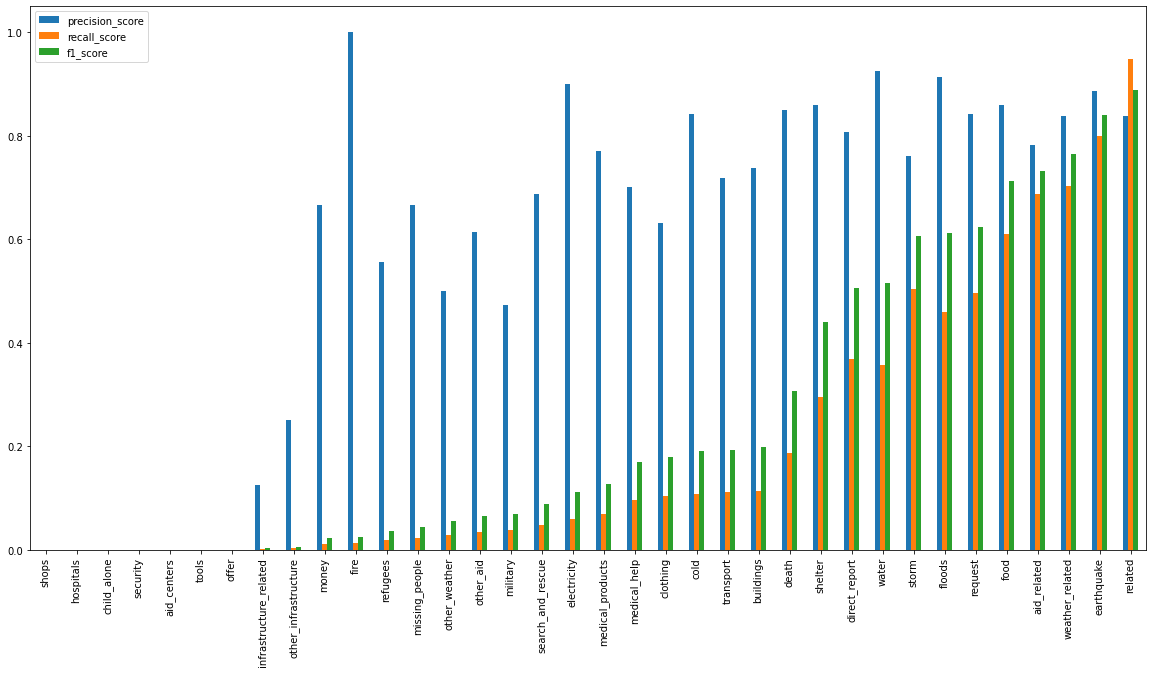

In [41]:
cv_res[['precision_score', 'recall_score', 'f1_score']].sort_values('f1_score').plot.bar(figsize=(20, 10))

<AxesSubplot:>

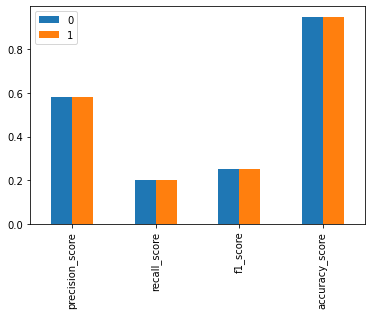

In [48]:
macro_cv_res = cv_res.mean()
pd.DataFrame([macro_cv_res, macro_res]).T.plot.bar()


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [132]:
pipeline = Pipeline([
    ('union', FeatureUnion([
        ('count', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize)),
            ('tfidf', TfidfTransformer()),
        ])),
        ('question', QuestionMarkFeature()),
        ('txtlen', TextLengthFeature())
    ])),
    ('clf', MultiOutputClassifier(RandomForestClassifier()))
])

In [133]:
max_samples = -1
pipeline.fit(X_train.iloc[:max_samples], y_train.iloc[:max_samples])

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('count',
                                                 Pipeline(steps=[('vect',
                                                                  CountVectorizer(tokenizer=<function tokenize at 0x000002715EDF6D30>)),
                                                                 ('tfidf',
                                                                  TfidfTransformer())])),
                                                ('question',
                                                 QuestionMarkFeature()),
                                                ('txtlen',
                                                 TextLengthFeature())])),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier()))])

In [134]:
y_pred = pipeline.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=y_test.columns)
print(classification_report(y_test, y_pred, target_names=y_test.columns))

                        precision    recall  f1-score   support

               related       0.82      0.96      0.89      5968
               request       0.86      0.49      0.62      1361
                 offer       0.00      0.00      0.00        41
           aid_related       0.77      0.70      0.73      3269
          medical_help       0.73      0.09      0.16       633
      medical_products       0.74      0.07      0.13       387
     search_and_rescue       0.71      0.05      0.10       230
              security       0.00      0.00      0.00       136
              military       0.77      0.07      0.13       238
           child_alone       0.00      0.00      0.00         0
                 water       0.90      0.32      0.47       490
                  food       0.86      0.53      0.66       897
               shelter       0.84      0.35      0.50       723
              clothing       0.57      0.07      0.12       115
                 money       0.67      

In [135]:
pipeline.get_params()

{'memory': None,
 'steps': [('union', FeatureUnion(transformer_list=[('count',
                                   Pipeline(steps=[('vect',
                                                    CountVectorizer(tokenizer=<function tokenize at 0x000002715EDF6D30>)),
                                                   ('tfidf',
                                                    TfidfTransformer())])),
                                  ('question', QuestionMarkFeature()),
                                  ('txtlen', TextLengthFeature())])),
  ('clf', MultiOutputClassifier(estimator=RandomForestClassifier()))],
 'verbose': False,
 'union': FeatureUnion(transformer_list=[('count',
                                 Pipeline(steps=[('vect',
                                                  CountVectorizer(tokenizer=<function tokenize at 0x000002715EDF6D30>)),
                                                 ('tfidf',
                                                  TfidfTransformer())])),
       

In [139]:
parameters = {
    'union__count__tfidf__sublinear_tf': [True, False],
    'union__count__vect__min_df': [1, 5, 20],
    'union__count__vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__estimator__max_depth': [5, 8],
    'clf__estimator__n_estimators': [100, 200, 300],
    'clf__n_jobs': [-1],
    'clf__estimator__class_weight': ['balanced']
}

cv = GridSearchCV(pipeline, parameters, verbose=4)
cv.fit(X, Y)

3/5] END clf__estimator__class_weight=balanced, clf__estimator__max_depth=8, clf__estimator__n_estimators=300, clf__n_jobs=-1, union__count__tfidf__sublinear_tf=True, union__count__vect__min_df=5, union__count__vect__ngram_range=(1, 1);, score=0.052 total time=  35.3s
[CV 4/5] END clf__estimator__class_weight=balanced, clf__estimator__max_depth=8, clf__estimator__n_estimators=300, clf__n_jobs=-1, union__count__tfidf__sublinear_tf=True, union__count__vect__min_df=5, union__count__vect__ngram_range=(1, 1);, score=0.053 total time=  34.4s
[CV 5/5] END clf__estimator__class_weight=balanced, clf__estimator__max_depth=8, clf__estimator__n_estimators=300, clf__n_jobs=-1, union__count__tfidf__sublinear_tf=True, union__count__vect__min_df=5, union__count__vect__ngram_range=(1, 1);, score=0.064 total time=  34.6s
[CV 1/5] END clf__estimator__class_weight=balanced, clf__estimator__max_depth=8, clf__estimator__n_estimators=300, clf__n_jobs=-1, union__count__tfidf__sublinear_tf=True, union__count__

GridSearchCV(estimator=Pipeline(steps=[('union',
                                        FeatureUnion(transformer_list=[('count',
                                                                        Pipeline(steps=[('vect',
                                                                                         CountVectorizer(tokenizer=<function tokenize at 0x000002715EDF6D30>)),
                                                                                        ('tfidf',
                                                                                         TfidfTransformer())])),
                                                                       ('question',
                                                                        QuestionMarkFeature()),
                                                                       ('txtlen',
                                                                        TextLengthFeature())])),
                                       ('cl

In [144]:
cv.best_params_

{'clf__estimator__class_weight': 'balanced',
 'clf__estimator__max_depth': 8,
 'clf__estimator__n_estimators': 300,
 'clf__n_jobs': -1,
 'union__count__tfidf__sublinear_tf': True,
 'union__count__vect__min_df': 1,
 'union__count__vect__ngram_range': (1, 3)}

In [145]:
pipeline.set_params(**cv.best_params_)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('count',
                                                 Pipeline(steps=[('vect',
                                                                  CountVectorizer(ngram_range=(1,
                                                                                               3),
                                                                                  tokenizer=<function tokenize at 0x000002715EDF6D30>)),
                                                                 ('tfidf',
                                                                  TfidfTransformer(sublinear_tf=True))])),
                                                ('question',
                                                 QuestionMarkFeature()),
                                                ('txtlen',
                                                 TextLengthFeature())])),
                ('clf',
                 MultiOutputClassif

In [146]:
y_pred = pipeline.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=y_test.columns)
print(classification_report(y_test, y_pred, target_names=y_test.columns))


                        precision    recall  f1-score   support

               related       0.91      0.68      0.78      5968
               request       0.60      0.72      0.65      1361
                 offer       0.00      0.00      0.00        41
           aid_related       0.76      0.61      0.67      3269
          medical_help       0.41      0.40      0.41       633
      medical_products       0.33      0.40      0.36       387
     search_and_rescue       0.54      0.26      0.35       230
              security       0.12      0.02      0.04       136
              military       0.40      0.49      0.44       238
           child_alone       0.00      0.00      0.00         0
                 water       0.56      0.57      0.56       490
                  food       0.58      0.59      0.59       897
               shelter       0.54      0.51      0.53       723
              clothing       0.49      0.26      0.34       115
                 money       0.29      

d:\code\udacity\disaster-response-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\code\udacity\disaster-response-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\code\udacity\disaster-response-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\code\udacity\disaster-response-classifier\.ve

<AxesSubplot:>

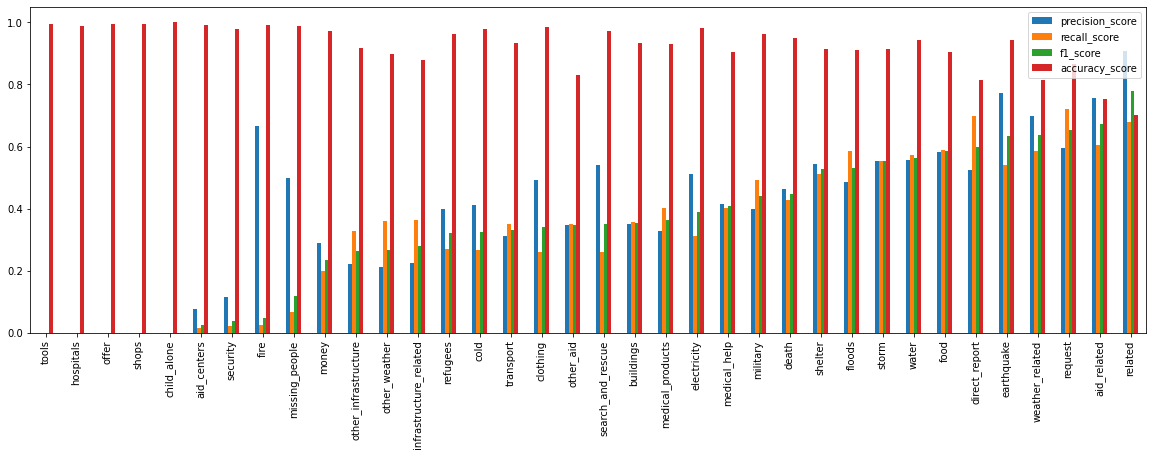

In [148]:
res = eval_metrics_per_category(y_test, y_pred)
res[['precision_score', 'recall_score', 'f1_score', 'accuracy_score']].sort_values('f1_score').plot.bar(figsize=(20, 6))

### Test NB model

In [150]:
nb_pipeline = Pipeline(
    [
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(MultinomialNB()))
    ]
)

nb_params = {
    'tfidf__sublinear_tf': True,
    'vect__ngram_range': (1, 3)
    }

nb_pipeline.set_params(**nb_params)
nb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(ngram_range=(1, 3),
                                 tokenizer=<function tokenize at 0x000002715EDF6D30>)),
                ('tfidf', TfidfTransformer(sublinear_tf=True)),
                ('clf', MultiOutputClassifier(estimator=MultinomialNB()))])

In [151]:
y_pred = nb_pipeline.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=y_test.columns)
print(classification_report(y_test, y_pred, target_names=y_test.columns))

                        precision    recall  f1-score   support

               related       0.77      1.00      0.87      5968
               request       0.94      0.13      0.22      1361
                 offer       0.00      0.00      0.00        41
           aid_related       0.79      0.54      0.65      3269
          medical_help       0.00      0.00      0.00       633
      medical_products       0.00      0.00      0.00       387
     search_and_rescue       0.00      0.00      0.00       230
              security       0.00      0.00      0.00       136
              military       0.00      0.00      0.00       238
           child_alone       0.00      0.00      0.00         0
                 water       0.00      0.00      0.00       490
                  food       0.93      0.01      0.03       897
               shelter       1.00      0.00      0.01       723
              clothing       0.00      0.00      0.00       115
                 money       0.00      

d:\code\udacity\disaster-response-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\code\udacity\disaster-response-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\code\udacity\disaster-response-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\code\udacity\disaster-response-classi

<AxesSubplot:>

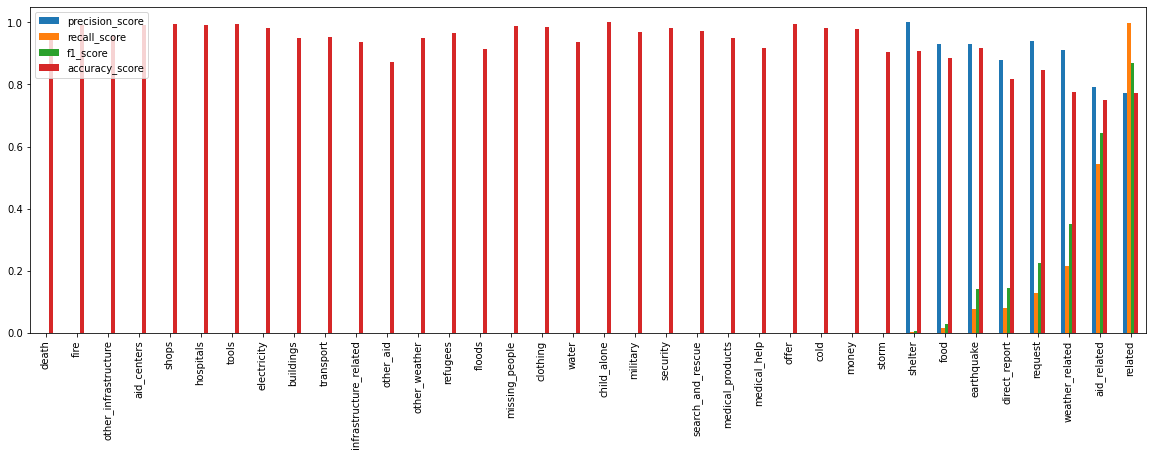

In [152]:
nb_res = eval_metrics_per_category(y_test, y_pred)
nb_res[['precision_score', 'recall_score', 'f1_score', 'accuracy_score']].sort_values('f1_score').plot.bar(figsize=(20, 6))

### 9. Export your model as a pickle file

In [ ]:
model_filepath = 'classifier.pkl'
model = pipeline

with open(model_filepath, 'wb') as out:
        joblib.dump(model, out)

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.